# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

model_id = "1.1.b.2.f"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1.a - df_test 04-19to05-19.feather', '1.1 - df_test 04-19to04-19.feather', '1.1.a - df_train  without nulls.feather', '1.1.a - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.1.b - 01-17 to 01-19 - df_val 01-19to03-19.feather', '1.1.a - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather', '1.1.a - df_train only 2018 without nulls.feather', '1.1.a - df_train with nan.feather']


## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [5]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [6]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [7]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [8]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-11-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-11-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-10-31 00:00:00
2018-11-01 00:00:00 2019-01-31 00:00:00


In [9]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.7785387199519812, 0.22146128004801874)

In [10]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [11]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [12]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [13]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [14]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

402088, 114377
402088, 114377


In [15]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.003484311891924156, 0.0050796925955393125)

## short optimization

In [16]:
'''from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
'''
#set_rf_samples(60000)

'from sklearn.ensemble import forest\ndef set_rf_samples(n):\n    """ Changes Scikit learn\'s random forests to give each tree a random sample of\n    n random rows.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n))\n\ndef reset_rf_samples():\n    """ Undoes the changes produced by set_rf_samples.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n_samples))\n'

## Defining grid configuration

In [17]:
from sklearn.utils.class_weight import compute_class_weight

In [18]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50192621, 130.28884965])

In [19]:
rf_params = {
    "n_estimators": [40, 200],  # 100, 400
    "min_samples_leaf": [4, 55], # , 65
     "max_depth": [5,  15], # 10,
#    "max_features": ['sqrt', 0.5, None],
    "class_weight": [{0:1, 1:9}, {0:1, 1:15},  {0:1, 1:18}] 
}

In [21]:
# using without grid with list of models
rfs = []
rfs.append(RandomForestClassifier(max_features="sqrt", random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rf.fit(X_full_train, y_full_train)

In [22]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "f1"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=rf_params, seed=random_state)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf.best_estimator_))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Comparing 24 parameter setting(s) using 8 CPU thread(s) ( 3 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

Best score: 0.473751600512164
Best config: {'class_weight': {0: 1, 1: 9}, 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 200}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Comparing 24 parameter setting(s) using 8 CPU thread(s) ( 3 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

Best score: 0.47593582887700536
Best config: {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 40}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [27]:
print("Best model of each family scores:")
for i in range(len(best_scores_)):
    print("%0.3f for %r" % (best_scores_[i], best_models_[i]))

Best model of each family scores:
0.474 for RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
0.476 for ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)


In [28]:
sorted_ids = np.argsort(clf.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (clf.scores[i], clf.params[i]))

Grid scores:
0.476 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 40}
0.474 for {'class_weight': {0: 1, 1: 9}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 200}
0.473 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 200}
0.473 for {'class_weight': {0: 1, 1: 9}, 'max_depth': 15, 'min_samples_leaf': 55, 'n_estimators': 40}
0.471 for {'class_weight': {0: 1, 1: 9}, 'max_depth': 15, 'min_samples_leaf': 55, 'n_estimators': 200}
0.469 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 200}
0.468 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 5, 'min_samples_leaf': 55, 'n_estimators': 200}
0.464 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 40}
0.463 for {'class_weight': {0: 1, 1: 18}, 'max_depth': 5, 'min_samples_leaf': 55, 'n_estimators': 40}
0.461 for {'class_weight': {0: 1, 1: 15}, 'max_depth': 15, 'min_s

In [29]:
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [30]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4347826086956522, 0.7800203961665493)

In [31]:
confusion_matrix(y_val, y_val_pred)

array([[71183,   320],
       [  135,   175]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [32]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
9,cond_C10,0.115078
30,es_gte_5,0.090882
88,TIPO_EXPED,0.073625
43,preg_15,0.069954
6,cond_32,0.054904
54,preg_33,0.049475
52,preg_31,0.039553
29,total_condicion,0.036556
10,cond_C11,0.032132
53,preg_32,0.029797


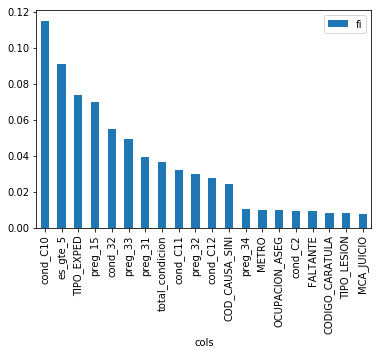

In [33]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [34]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 38 of 143


In [35]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
             "total_condicion", 
            ] # "es_gte_5",
for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['cond_C10',
 'es_gte_5',
 'TIPO_EXPED',
 'preg_15',
 'cond_32',
 'preg_33',
 'preg_31',
 'cond_C11',
 'preg_32',
 'cond_C12',
 'preg_34',
 'METRO',
 'OCUPACION_ASEG',
 'cond_C2',
 'FALTANTE',
 'CODIGO_CARATULA',
 'TIPO_LESION',
 'MCA_JUICIO',
 'TIPO_LESION_MAXIMA',
 'SEXO',
 'DESCRIPCION_TIPO',
 'SEXO_TERC',
 'CAPITAL_VEHICULO',
 'ESTADO_CIVIL',
 'COD_POST_POLIZA',
 'SEGMENTO',
 'TIPO_SINIESTRO',
 'COD_POST_OCURRENCIA',
 'FECHA_SINI_Month',
 'CODIGO_VEHICULO',
 'FECHA_SINI_Dayofweek',
 'CAPITAL_ASEGURADO_COTIZACION',
 'FECHA_SINI_Week',
 'COD_COBRO_ANTERIOR',
 'ESTAD_VEH_ASEG',
 'FECHA_SINI_Dayofyear']

In [36]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [37]:
X_train_red = X_train[to_keep].copy()

In [38]:
print(len(X_train_red.columns))

36


### Training again with less features

In [39]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [40]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4221698113207547, 0.7861992932396702)

In [41]:
confusion_matrix(y_val, y_val_pred)

array([[71144,   359],
       [  131,   179]])

In [42]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
0,cond_C10,0.109810
2,TIPO_EXPED,0.099857
1,es_gte_5,0.097093
3,preg_15,0.093542
7,cond_C11,0.072594
8,preg_32,0.058561
9,cond_C12,0.046881
4,cond_32,0.033199
6,preg_31,0.031119
5,preg_33,0.024835


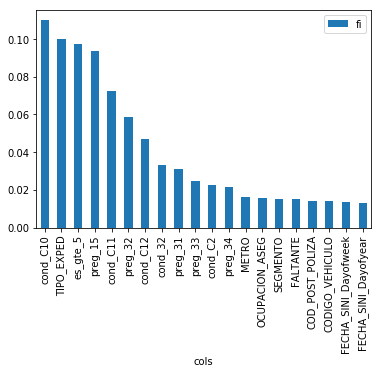

In [43]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [48]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [49]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.455, 0.973


In [50]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[71150,   353],
       [  115,   195]])

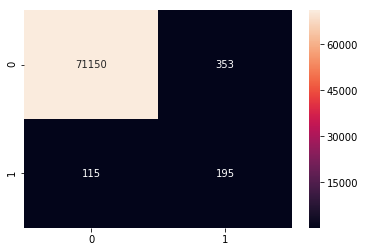

In [51]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [57]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 15},
           criterion='gini', max_depth=15, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [45]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.448, 0.970


In [46]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[71144,   359],
       [  117,   193]])

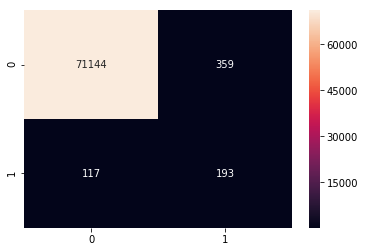

In [47]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [71]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3472949389179756,0.8165133833771018)


In [72]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[70866,   637],
       [  111,   199]])

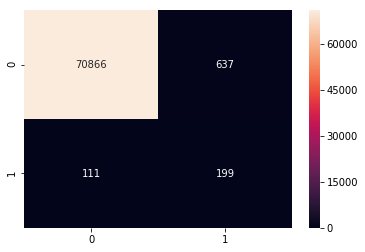

In [73]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [51]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, f"{model_id}(Model) - Model Optimization {metric} - class_weight {(rf_full.class_weight[0], rf_full.class_weight[1])} - time sorted - valid score ({metric_results}).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [52]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [53]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'TIPO_EXPED', 'preg_15', 'es_gte_5', 'preg_31', 'preg_33', 'cond_32', 'preg_32', 'cond_C11', 'cond_C12', 'cond_C2', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'preg_34', 'cond_C5']


In [54]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - features: {len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [52]:
df_test = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [56]:
# Loding the model

def load_model(file_name):
    """Load the dump model."""
    folder = "models"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    model_file = os.path.join(path_to_load, file_name)

    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(file_name):
    """Load the array of columns use in the dump model."""
    folder = "features"
    path_to_load = f"../../src/{folder}/1.1 - df_train 01-18to12-18"
    columns_file = os.path.join(path_to_load, file_name)

    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [57]:
model_name = "1.1.b.2.f(Model) - Model Optimization recall - class_weight (1, 18) - time sorted - valid score (0.403, 0.972).pickle"
columns_name = "1.1.b.2.f (COLUMNS) - features: 17.pickle"
m = load_model(model_name)
columns = load_columns(columns_name)

In [53]:
columns = to_keep

In [54]:
X_test = df_test.loc[:, columns]
y_test = df_test["EXISTE_FRAUDE"]

In [55]:
X_test.head()

,cond_C10,es_gte_5,TIPO_EXPED,preg_15,cond_32,preg_33,preg_31,cond_C11,preg_32,cond_C12,preg_34,METRO,OCUPACION_ASEG,cond_C2,FALTANTE,CODIGO_CARATULA,TIPO_LESION,MCA_JUICIO,TIPO_LESION_MAXIMA,SEXO,DESCRIPCION_TIPO,SEXO_TERC,CAPITAL_VEHICULO,ESTADO_CIVIL,COD_POST_POLIZA,SEGMENTO,TIPO_SINIESTRO,COD_POST_OCURRENCIA,FECHA_SINI_Month,CODIGO_VEHICULO,FECHA_SINI_Dayofweek,CAPITAL_ASEGURADO_COTIZACION,FECHA_SINI_Week,COD_COBRO_ANTERIOR,ESTAD_VEH_ASEG,FECHA_SINI_Dayofyear
0,-1.0,False,3,-1,-1.0,-1,-1,-1.0,-1,-1.0,-1,1,44.0,-1.0,1,-1.0,-1,-1,-1,1,3,-1,4514,0,1439.0,5,5,1439.0,4.0,18380.0,0.0,2293,14.0,0,5.0,91.0
1,-1.0,False,3,-1,-1.0,-1,-1,-1.0,-1,-1.0,-1,1,5.0,-1.0,1,-1.0,-1,-1,-1,1,3,-1,3913,0,1684.0,4,5,1708.0,4.0,6846.0,0.0,1985,14.0,0,3.0,91.0
2,-1.0,False,5,-1,-1.0,-1,-1,-1.0,1,-1.0,-1,1,44.0,3.0,1,-1.0,-1,-1,-1,1,3,-1,674,6,1407.0,4,6,1678.0,4.0,2605.0,0.0,433,14.0,-1,3.0,91.0
3,-1.0,False,2,-1,-1.0,-1,-1,-1.0,-1,-1.0,-1,0,44.0,-1.0,1,-1.0,-1,-1,-1,1,3,1,4838,6,5178.0,5,9,5178.0,4.0,5611.0,0.0,2359,14.0,5,3.0,91.0
4,-1.0,False,3,-1,-1.0,-1,-1,-1.0,-1,-1.0,-1,0,44.0,-1.0,1,-1.0,-1,-1,-1,1,3,-1,4838,6,5178.0,5,9,5178.0,4.0,5611.0,0.0,2359,14.0,5,3.0,91.0


## Model in test

In [58]:
y_test_pred_prob = rf_full.predict_proba(X_test)[:, -1]
print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.418, 0.989


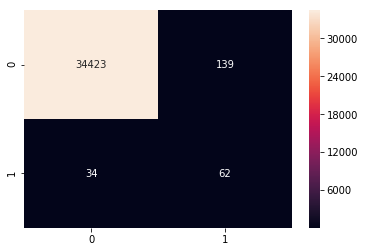

In [59]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [63]:
y_tronador = X_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


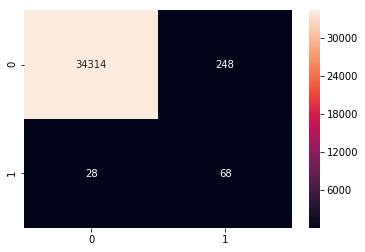

In [64]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")